# Импорты и настройки

In [ ]:
import shutil
from pathlib import Path
from copy import deepcopy

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

# Загрузка данных

In [2]:
ds_local_dir = Path("chest_xray")

if not ds_local_dir.exists():
    ds_folder_path = kagglehub.dataset_download(
        "paultimothymooney/chest-xray-pneumonia"
    )  # загрузим данные
    print(f"Dataset saved to: {ds_folder_path}")

    ds_dir = Path(ds_folder_path) / "chest_xray" / "chest_xray"

    ds_dir.rename(ds_local_dir)  # перенесём данные в текущую директорию
    shutil.rmtree(
        Path(ds_folder_path).parent.parent.parent
    )  # удалим датасет из директории kagglehub
print(f"Dataset saved to: {ds_local_dir}")

100%|██████████████████████████████████████████████████████████████████████████████████████| 2.29G/2.29G [01:06<00:00, 37.2MB/s]

Extracting files...


Dataset saved to: /home/nortlite/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Dataset saved to: chest_xray


# EDA
Для начала посмотрим в директорию `train` и `test`, директорию `val` рассматривать не будем, т.к. там всего по 8 элементов категории больных и здоровых, я добавил эти снимки в тренировочную выборку.

В наборе данных со снимками лёгких с пневмонией видно что категория "больные" делится ещё на две подгруппы `virus` и `bacteria`, очевидно снимки лёгких с вирусной и бактериальной пневмонией.

Для удобства составления датасета для обучения и валидации я разделю данные следующим образом: все снимки здоровых лёгких я помещу в директорию `normal`. Снимки с бактериальной пневмонией поместим в директорию `bacteria` а снимки с вирусной пневмонией в директорию `virus`.

In [3]:
data_dir = Path("chest_xray")
train_dir = data_dir / "train"
test_dir = data_dir / "test"
val_dir = data_dir / "val"

# перенесём все снимки без заболеваний из val директороии в train
for file in (val_dir / "NORMAL").glob("*.jpeg"):
    file.rename(train_dir / "NORMAL" / file.name)
# перенесём все снимки больными лёгкими из val директороии в train
for file in (val_dir / "PNEUMONIA").glob("*.jpeg"):
    file.rename(train_dir / "PNEUMONIA" / file.name)

# создадим директории normal, virus и bacteria в train и test директориях
train_normal_dir = train_dir / "NORMAL"
train_normal_dir = train_normal_dir.rename(train_dir / "normal")
train_bacteria_dir = train_dir / "bacteria"
train_bacteria_dir.mkdir(exist_ok=True, parents=True)
train_virus_dir = train_dir / "virus"
train_virus_dir.mkdir(exist_ok=True, parents=True)

test_normal_dir = test_dir / "NORMAL"
test_normal_dir = test_normal_dir.rename(test_dir / "normal")
test_bacteria_dir = test_dir / "bacteria"
test_bacteria_dir.mkdir(exist_ok=True, parents=True)
test_virus_dir = test_dir / "virus"
test_virus_dir.mkdir(exist_ok=True, parents=True)

# перенесём соответствующие снимки по соответствующим директориям
for file in (train_dir / "PNEUMONIA").glob("*_bacteria_*.jpeg"):
    file.rename(train_bacteria_dir / file.name)

for file in (train_dir / "PNEUMONIA").glob("*_virus_*.jpeg"):
    file.rename(train_virus_dir / file.name)

for file in (test_dir / "PNEUMONIA").glob("*_bacteria_*.jpeg"):
    file.rename(test_bacteria_dir / file.name)

for file in (test_dir / "PNEUMONIA").glob("*_virus_*.jpeg"):
    file.rename(test_virus_dir / file.name)

# удалим ненужные директории
if (train_dir / "PNEUMONIA").exists():
    shutil.rmtree(train_dir / "PNEUMONIA")
    shutil.rmtree(test_dir / "PNEUMONIA")
    shutil.rmtree(val_dir)

Посмотрим каково распределение классов в данных для обучения и в тестовых данных:

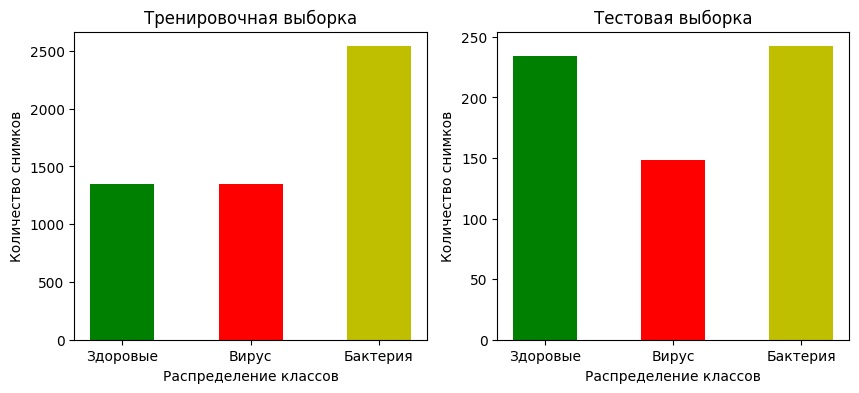

In [4]:
train_0_count = len(list(train_normal_dir.glob("*.jpeg")))
train_1_count = len(list(train_virus_dir.glob("*.jpeg")))
train_2_count = len(list(train_bacteria_dir.glob("*.jpeg")))

test_0_count = len(list(test_normal_dir.glob("*.jpeg")))
test_1_count = len(list(test_virus_dir.glob("*.jpeg")))
test_2_count = len(list(test_bacteria_dir.glob("*.jpeg")))

fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
ax[0].bar(0, train_0_count, width=0.25, color="g")
ax[0].bar(0.5, train_1_count, width=0.25, color="r")
ax[0].bar(1, train_2_count, width=0.25, color="y")
ax[0].set_ylabel("Количество снимков")
ax[0].set_xlabel("Распределение классов")
ax[0].set_xticks([0, 0.5, 1], ["Здоровые", "Вирус", "Бактерия"])
ax[0].set_title("Тренировочная выборка")

ax[1].bar(0, test_0_count, width=0.25, color="g")
ax[1].bar(0.5, test_1_count, width=0.25, color="r")
ax[1].bar(1, test_2_count, width=0.25, color="y")
ax[1].set_ylabel("Количество снимков")
ax[1].set_xlabel("Распределение классов")
ax[1].set_xticks([0, 0.5, 1], ["Здоровые", "Вирус", "Бактерия"])
ax[1].set_title("Тестовая выборка")
plt.show()

Как можем заметить присутствует дисбаланс классов - снимков с бактериальной пневмонией немногим менее чем в 2 раза больше. Попробуем пока не убирать данный дисбаланс; если далее мы поймём что это повлияет на качество обученной модели - то попробуем немного сократить количество снимков с бактериальной пневмонией.

Отобразим несколько изображений из тренировочного датасета, для этого сначала составим объекты тренировочного и тестового датасета. Сразу добавим слой нормализации изображений, для приведения значени от `[0 - 255]` к `[0 - 1]`. В превью будут изображения сразу с применеными аугментациями.

Found 5232 files belonging to 3 classes.


I0000 00:00:1750449504.769376   39691 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 624 files belonging to 3 classes.


2025-06-20 21:58:26.059373: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


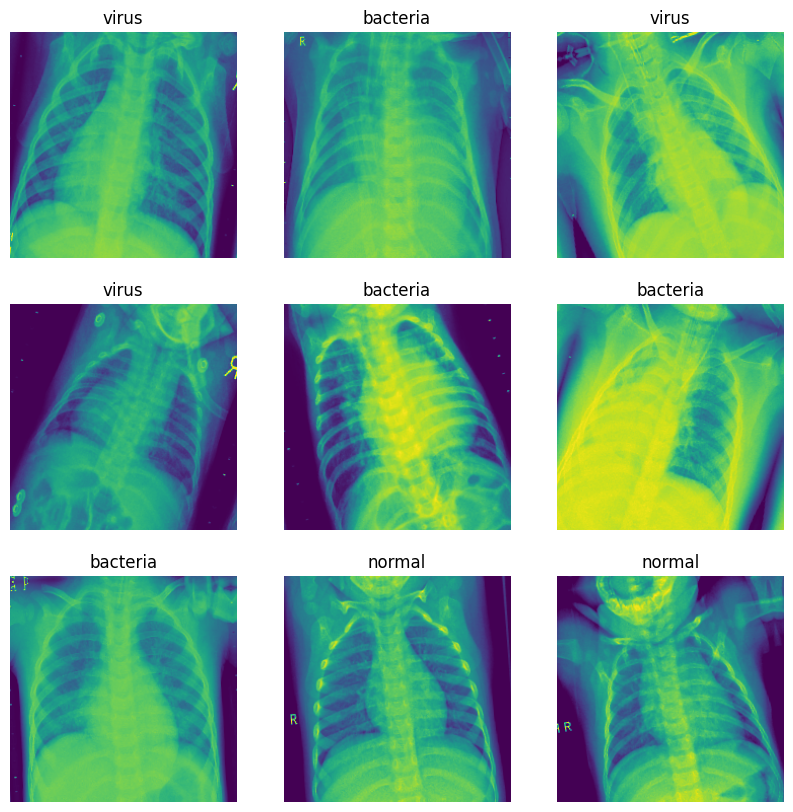

In [5]:
NUM_CLASSES = 3
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 10

# тренировочный датасет
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    color_mode="grayscale",
    image_size=IMG_SIZE,  # преобразование изображение к размеру 224 x 224
    label_mode="categorical",  # это сделает one-hot encoding для целевых значений
    shuffle=True,
)

# тестовый датасет
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    color_mode="grayscale",
    image_size=IMG_SIZE,  # преобразование изображение к размеру 224 x 224
    label_mode="categorical",  # это сделает one-hot encoding для целевых значений
    shuffle=True,
)

# слой нормализации изображений, что бы значения изображений были в диапазоне от 0 до 1
normalization_layer = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

# Добавим нормализацию и аугментации к тренировочным данным
# слой для рандомного горизонтального "флипа" изображения
data_augmentation_layer = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(
            "horizontal",
            seed=SEED,
        ),  # только горизонтальный флип, кажется что производить переворачивание изображения снизу-вверх нет смысла
        tf.keras.layers.RandomRotation((-0.05, 0.05), seed=SEED),  # поворот на -5/5 %
    ]
)

# копируем слои для превью
preview_norm = deepcopy(normalization_layer)
preview_aug = deepcopy(data_augmentation_layer)

fig, axs = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)
for X, y in train_ds.take(1):
    for i in range(9):
        x = preview_norm(X[i])
        x = preview_aug(x)
        axs[i // 3][i % 3].imshow(x)
        axs[i // 3][i % 3].set_title(train_ds.class_names[y[i].numpy().argmax()])
        axs[i // 3][i % 3].axis("off")

plt.show()

# Тренировка базовой модели

Для начала добавим кастомные метрики Precision, Recall, F1-Score, т.к. в фреймворке tensorflow нет готовой реализации для многоклассовой классификации:

In [6]:
class OneHotPrecision(tf.keras.metrics.Precision):
    def __init__(self, num_classes, name="precision", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=self.num_classes)
        super().update_state(y_true, y_pred, sample_weight)


class OneHotRecall(tf.keras.metrics.Recall):
    def __init__(self, num_classes, name="recall", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=self.num_classes)
        super().update_state(y_true, y_pred, sample_weight)


class F1Score(tf.keras.metrics.Metric):

    def __init__(self, num_classes, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = OneHotPrecision(num_classes)
        self.recall = OneHotRecall(num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * p * r / (p + r + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

Далее обучим модель. Модель будет состоять из одного свёрточного слоя, MaxPooling слоя, а так же одного полносвязного и одного выходного слоя. Добавим метрики, описанные выше в пайплайн обучения для отслеживания показателей по эпохам и возможности построить графики.

In [7]:
model = tf.keras.Sequential(
    [
        normalization_layer,
        data_augmentation_layer,
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),  # количество классов - 3
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.metrics.CategoricalAccuracy(name="accuracy"),
        OneHotPrecision(NUM_CLASSES),
        OneHotRecall(NUM_CLASSES),
        F1Score(NUM_CLASSES),
        tf.keras.metrics.AUC(multi_label=True, num_labels=NUM_CLASSES, name="roc_auc"),
    ],
)

history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

model.summary()

Epoch 1/10


I0000 00:00:1750449507.679394   41218 cuda_dnn.cc:529] Loaded cuDNN version 90300


164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5712 - f1: 0.5712 - loss: 3.9466 - precision: 0.5712 - recall: 0.5712 - roc_auc: 0.6735 - val_accuracy: 0.7163 - val_f1: 0.7163 - val_loss: 0.6923 - val_precision: 0.7163 - val_recall: 0.7163 - val_roc_auc: 0.9044
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7389 - f1: 0.7389 - loss: 0.5838 - precision: 0.7389 - recall: 0.7389 - roc_auc: 0.8642 - val_accuracy: 0.7804 - val_f1: 0.7804 - val_loss: 0.5946 - val_precision: 0.7804 - val_recall: 0.7804 - val_roc_auc: 0.9121
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7596 - f1: 0.7596 - loss: 0.5504 - precision: 0.7596 - recall: 0.7596 - roc_auc: 0.8782 - val_accuracy: 0.7724 - val_f1: 0.7724 - val_loss: 0.5709 - val_precision: 0.7724 - val_recall: 0.7724 - val_roc_auc: 0.9171
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7544 - f1: 0.7544 - loss: 0.5456 - precision: 0.7544 - recall: 0.7544 - roc_auc: 0.8799 - val_accurac

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    50,466,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,402,955 (577.56 MB)

 Trainable params: 50,467,651 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100,935,304 (385.04 MB)

Посмотрим на графики метрик в зависимости от эпохи.

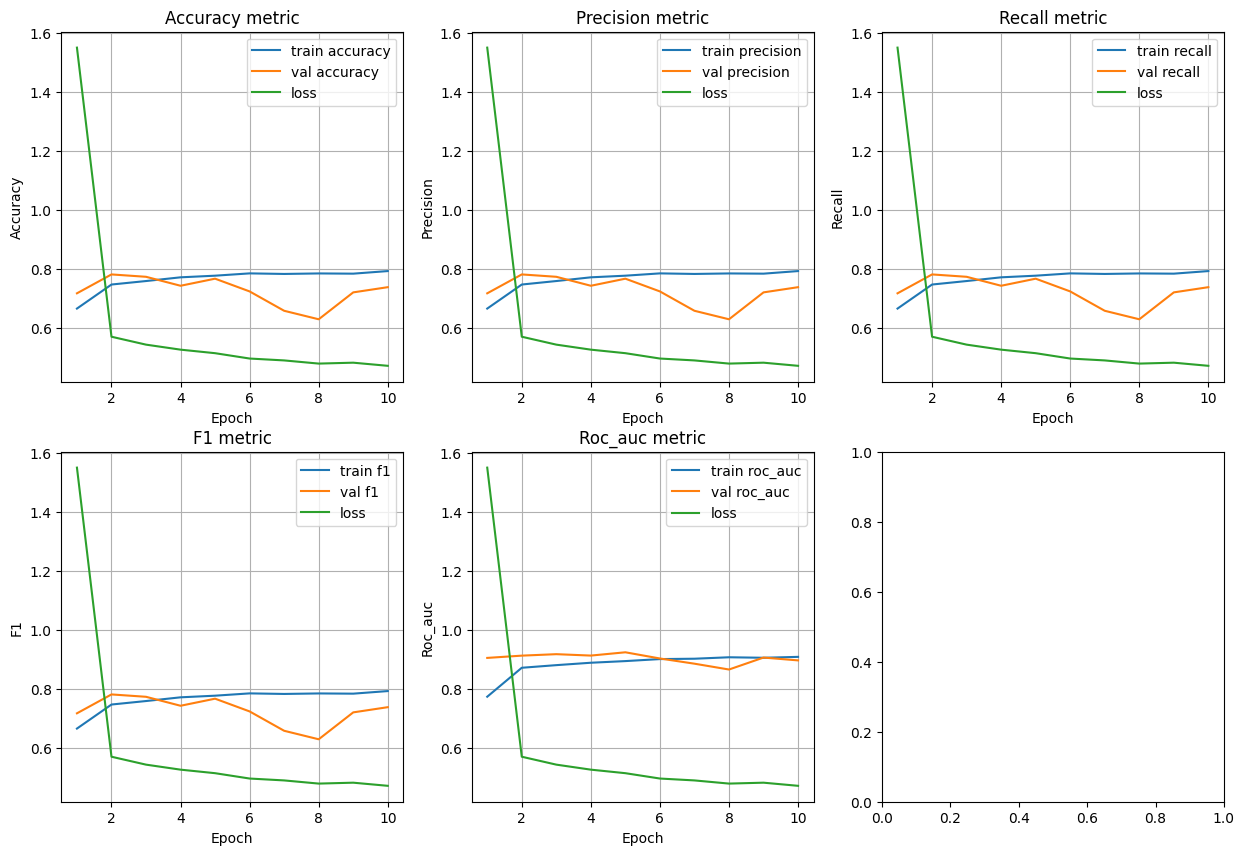

In [8]:
epochs = range(1, EPOCHS + 1)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, metric in enumerate(["accuracy", "precision", "recall", "f1", "roc_auc"]):
    axs[i // 3][i % 3].plot(epochs, history.history[metric], label=f"train {metric}")
    axs[i // 3][i % 3].plot(
        epochs, history.history[f"val_{metric}"], label=f"val {metric}"
    )
    axs[i // 3][i % 3].plot(epochs, history.history[f"loss"], label=f"loss")
    axs[i // 3][i % 3].set_xlabel("Epoch")
    axs[i // 3][i % 3].set_ylabel(metric.capitalize())
    axs[i // 3][i % 3].set_title(f"{metric.capitalize()} metric")
    axs[i // 3][i % 3].legend()
    axs[i // 3][i % 3].grid(True)

Видим что значение Accuracy на тестовой выборке в среднем составляет 0.73, это не очень хороший показатель, но для такой простой сети вполне приемлемый; так же стоит отметить что мы достигли порогового значения `ROC-AUC >= 0.8`.

# Использование предобученной модели

> При решении задания, я подумал что воспользоваться предобученной моделью и дообучить её на предоставленных данных. В моём случае это оказалось быстрее и данный подход дал лучшие показатели метрик. 

Воспользуемся предобученной моделью `MobileNetV2`. Для этого нам надо сотавить новый датасет с `color_mode = "rgb"` потому что модель ожидает цветные изображения.

Стоит отметить что мы "замораживаем" базовую модель. Предположительно это должно улучшить результаты дообучения. Так же я добавил дополнительную "голову" модели - это два полносвязных слоя с размерами 128 и 64 соответственно.

После нескольких запусков, имперически было выявлено что остановка обучения на 13 эпохах даёт наилучшие показатели метрик.

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

NUM_CLASSES = 3
IMG_SIZE = (224, 224)
NET_INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 13

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    color_mode="rgb",  # MobileNet ждёт 3-канальный ввод
    image_size=IMG_SIZE,
    label_mode="categorical",
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    seed=SEED,
    color_mode="rgb",
    image_size=IMG_SIZE,
    label_mode="categorical",
)


data_aug_layer = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal", seed=SEED),
        tf.keras.layers.RandomRotation(0.05, seed=SEED),
    ]
)

base_model = MobileNetV2(
    include_top=False, weights="imagenet", input_shape=NET_INPUT_SHAPE
)

# Делаем базовую модель необучаемой
base_model.trainable = False

model = tf.keras.Sequential(
    [
        normalization_layer,
        data_aug_layer,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3, seed=SEED),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4, seed=SEED),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25, seed=SEED),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        OneHotPrecision(NUM_CLASSES),
        OneHotRecall(NUM_CLASSES),
        F1Score(NUM_CLASSES),
        tf.keras.metrics.AUC(multi_label=True, num_labels=NUM_CLASSES, name="roc_auc"),
    ],
)

history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

model.summary()

Found 5232 files belonging to 3 classes.
Found 624 files belonging to 3 classes.
Epoch 1/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5443 - f1: 0.5443 - loss: 1.1108 - precision: 0.5443 - recall: 0.5443 - roc_auc: 0.7263 - val_accuracy: 0.6250 - val_f1: 0.6250 - val_loss: 1.0201 - val_precision: 0.6250 - val_recall: 0.6250 - val_roc_auc: 0.8813
Epoch 2/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7193 - f1: 0.7193 - loss: 0.6661 - precision: 0.7193 - recall: 0.7193 - roc_auc: 0.8584 - val_accuracy: 0.7580 - val_f1: 0.7580 - val_loss: 0.6685 - val_precision: 0.7580 - val_recall: 0.7580 - val_roc_auc: 0.9212
Epoch 3/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7349 - f1: 0.7349 - loss: 0.6209 - precision: 0.7349 - recall: 0.7349 - roc_auc: 0.8644 - val_accuracy: 0.7644 - val_f1: 0.7644 - val_loss: 0.6307 - val_precision: 0.7644 - val_recall: 0.7644 - val_roc_auc: 0.9248
Epoch 4/13
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7638 - f1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,776,779 (10.59 MB)

 Trainable params: 172,803 (675.01 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

 Optimizer params: 345,608 (1.32 MB)

Выведем результаты работы модели и метрики на экран.

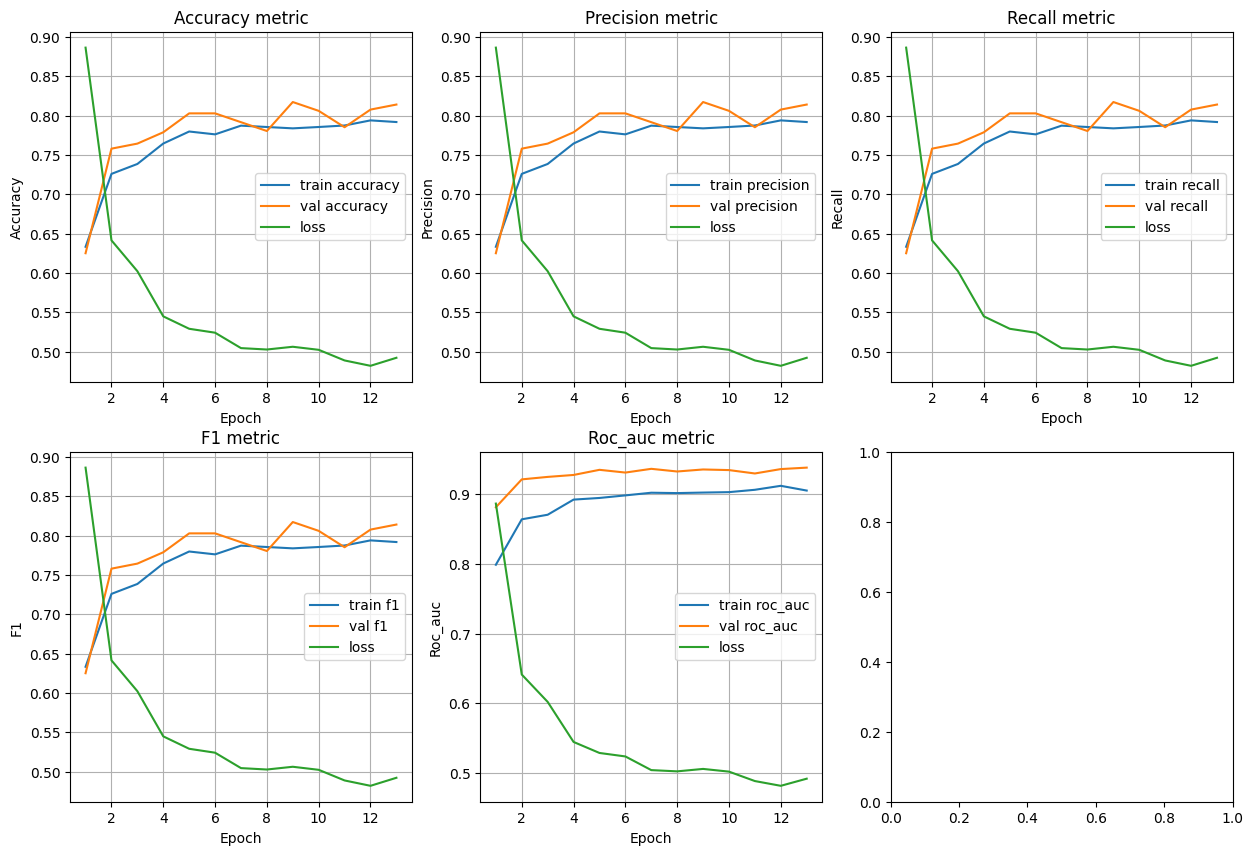

In [11]:
epochs = range(1, EPOCHS + 1)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, metric in enumerate(["accuracy", "precision", "recall", "f1", "roc_auc"]):
    axs[i // 3][i % 3].plot(epochs, history.history[metric], label=f"train {metric}")
    axs[i // 3][i % 3].plot(
        epochs, history.history[f"val_{metric}"], label=f"val {metric}"
    )
    axs[i // 3][i % 3].plot(epochs, history.history[f"loss"], label=f"loss")
    axs[i // 3][i % 3].set_xlabel("Epoch")
    axs[i // 3][i % 3].set_ylabel(metric.capitalize())
    axs[i // 3][i % 3].set_title(f"{metric.capitalize()} metric")
    axs[i // 3][i % 3].legend()
    axs[i // 3][i % 3].grid(True)

Показатели метрик заметно улучшились, что не удивительно, т.к. мы использовали более сложную и предобученную модель на большом датасете из изображений `imagenet`. Мы получаем значения `Accuracy` ~0.81 на тестовых данных, даже не смотря на тот факт, что изначально в датасете `imagenet` нет изображений с рентгеновскими снимками лёгких.

# Выводы

Transfer-learning с MobileNetV2 в большинстве прикладных сценариев выигрывает по метрикам, времени обучения и удобству эксплуатации.

Собственная CNN остаётся полезной, если проект требует полной кастомизации архитектуры или обрабатывает "экзотические" входные данные.

Так же для себя я заключил следующие рекомендации на будущее: начинать с больших предобученных моделей, подходящих под мою задачу (если таковые модели есть), и переходить к собственной реализации только при чётко обоснованных требованиях, не покрываемых transfer-learning.